In [1]:
!pip install keras
!pip install sklearn
!pip install matplotlib
!pip install -U -q PyDrive

In [2]:
from keras import backend as K
K.clear_session()

Using TensorFlow backend.


In [0]:
from keras import backend as K
cfg = K.tf.ConfigProto()
cfg.gpu_options.allow_growth = True
K.set_session(K.tf.Session(config=cfg))

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
file_import = drive.CreateFile({'id':'1p1bsltfTcIrZ_kfE6kwGTPzcdXorHbb2'})
file_import.GetContentFile('colab_setup.py') 
from colab_setup import setup

setup(drive)

In [6]:
!ls

colab_setup.py			 roc_auc_callback.py	X_train.npy
custom_fast_text_embeddings.npy  sample_submission.csv	X_val.npy
datalab				 train_model.py		y_test.npy
fast_text_embeddings.npy	 X_submission.npy	y_train_full.npy
plot_history.py			 X_test.npy		y_train.npy
__pycache__			 X_train_full.npy	y_val.npy


In [0]:
import numpy as np
import os

from plot_history import plot_history
from roc_auc_callback import RocAucCallback
from train_model import train_with_cv, train_with_submitting, evaluate_on_test

from keras.models import Model
from keras.layers import *
from keras.initializers import *
from keras.layers.merge import concatenate

In [0]:
def one_by_one(filtersNumber, inputLayer, dropout = 0.2):
    one_by_one = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    one_by_one = BatchNormalization()(one_by_one)
    one_by_one = SpatialDropout1D(dropout)(one_by_one)
    
    return one_by_one

In [0]:
def highway_conv_1d(inputLayer, filtersNumber, dropout = 0.2, keepInitialBias = -2):
    highwayInput = Input(shape=(400, 300))
    convolution = one_by_one(filtersNumber, highwayInput, dropout)
    
    keep = Conv1D(
        filtersNumber, 1, 
        activation = 'sigmoid',
        padding = 'same', 
        kernel_initializer = 'he_uniform',
        bias_initializer = Constant(keepInitialBias)
    )(highwayInput)
    
    keep = BatchNormalization()(keep)
    forget = Lambda(lambda layer: 1 - layer)(keep)
    
    gate = add(
        [
            multiply([keep, convolution]),
            multiply([forget, highwayInput])
        ]
    )
    
    return Model(inputs=[highwayInput], outputs = [gate])(inputLayer)

In [0]:
def highway_block(inputLayer, filtersNumber, convolutions = 3):
    block = inputLayer
    for i in range(convolutions):
       block = highway_conv_1d(block, filtersNumber)
    return block

In [0]:
def yoon_kim_feature_extractor(filtersNumber, inputLayer):
    block_1_conv_1 = Conv1D(filtersNumber, 1, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm1 = BatchNormalization()(block_1_conv_1)
    block_1_max_pool1 = GlobalMaxPooling1D()(block_1_batchnorm1)

    block_1_conv_2 = Conv1D(filtersNumber, 2, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm2 = BatchNormalization()(block_1_conv_2)
    block_1_max_pool2 = GlobalMaxPooling1D()(block_1_batchnorm2)

    block_1_conv_3 = Conv1D(filtersNumber, 3, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm3 = BatchNormalization()(block_1_conv_3)
    block_1_max_pool3 = GlobalMaxPooling1D()(block_1_batchnorm3)

    block_1_conv_4 = Conv1D(filtersNumber, 5, activation = 'elu', padding = 'same', kernel_initializer = 'he_uniform')(inputLayer)
    block_1_batchnorm4 = BatchNormalization()(block_1_conv_4)
    block_1_max_pool4 = GlobalMaxPooling1D()(block_1_batchnorm4)

    block_1_features = concatenate([
        block_1_max_pool1, 
        block_1_max_pool2, 
        block_1_max_pool3, 
        block_1_max_pool4
    ])
    block_1_features = Dropout(0.2)(block_1_features)
    return block_1_features

In [12]:
maxWords = 30000
maxSequenceLengthInWords = 400
embeddingDimension = 300
filtersNumber = 300

input_layer = Input(shape=(maxSequenceLengthInWords,))

pretrained_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
pretrained_embedding_layer = SpatialDropout1D(0.2)(pretrained_embedding_layer)

custom_embedding_layer = Embedding(
    maxWords, 
    output_dim=embeddingDimension, 
    input_length=maxSequenceLengthInWords,
    weights = [np.load('custom_fast_text_embeddings.npy')],
    trainable = False
)(input_layer)
custom_embedding_layer = SpatialDropout1D(0.2)(custom_embedding_layer)

embedding = Average()([pretrained_embedding_layer, custom_embedding_layer])
embedding_dropout = SpatialDropout1D(0.2)(embedding)

highway = highway_block(embedding_dropout, 300, 12)

features = yoon_kim_feature_extractor(filtersNumber, highway)

dense_1 = Dense(256, activation = 'elu')(features)
dense_1_normalization = BatchNormalization()(dense_1)
dense_1_dropout = Dropout(0.2)(dense_1_normalization)

dense_2 = Dense(256, activation = 'elu')(dense_1_dropout)
dense_2_normalization = BatchNormalization()(dense_2)
dense_2_dropout = Dropout(0.2)(dense_2_normalization)

output_layer = Dense(6, activation='sigmoid')(dense_2_dropout)

model = Model(inputs=[input_layer], outputs=[output_layer])
            
model.summary()

model.compile(
    loss='binary_crossentropy', 
    optimizer='Adam',
    metrics=['accuracy']
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 400, 300)     9000000     input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 400, 300)     0           embedding_1[0][0]                
__________________________________________________________________________________________________
spatial_dr

In [13]:
history = train_with_cv(model, batchSize=32, rocEvery = 2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/32
 21312/102124 [=====>........................] - ETA: 20:45 - loss: 0.2384 - acc: 0.9199

102112/102124 [============================>.] - ETA: 0s - loss: 0.1603 - acc: 0.9538

102124/102124 [==============================] - 1652s 16ms/step - loss: 0.1603 - acc: 0.9538 - val_loss: 0.1500 - val_acc: 0.9632
Epoch 2/32
 10080/102124 [=>............................] - ETA: 22:50 - loss: 0.1372 - acc: 0.9616

102112/102124 [============================>.] - ETA: 0s - loss: 0.1305 - acc: 0.9627

102124/102124 [==============================] - 1640s 16ms/step - loss: 0.1305 - acc: 0.9627 - val_loss: 0.1614 - val_acc: 0.9637
roc-auc: 0.7982 - roc-auc_val: 0.7991                                                                                                    
Epoch 3/32
  8640/102124 [=>............................] - ETA: 23:12 - loss: 0.1328 - acc: 0.9611

102112/102124 [============================>.] - ETA: 0s - loss: 0.1239 - acc: 0.9635

102124/102124 [==============================] - 1631s 16ms/step - loss: 0.1239 - acc: 0.9635 - val_loss: 0.1348 - val_acc: 0.9639
Epoch 4/32
 10080/102124 [=>............................] - ETA: 22:30 - loss: 0.1067 - acc: 0.9668

102112/102124 [============================>.] - ETA: 0s - loss: 0.1111 - acc: 0.9655

102124/102124 [==============================] - 1630s 16ms/step - loss: 0.1111 - acc: 0.9655 - val_loss: 0.1326 - val_acc: 0.9637
roc-auc: 0.8997 - roc-auc_val: 0.8962                                                                                                    
Epoch 5/32
  8640/102124 [=>............................] - ETA: 23:08 - loss: 0.1157 - acc: 0.9644

102112/102124 [============================>.] - ETA: 0s - loss: 0.1087 - acc: 0.9661

102124/102124 [==============================] - 1638s 16ms/step - loss: 0.1087 - acc: 0.9661 - val_loss: 0.1516 - val_acc: 0.9637
Epoch 6/32
 10080/102124 [=>............................] - ETA: 22:49 - loss: 0.1066 - acc: 0.9662

102112/102124 [============================>.] - ETA: 0s - loss: 0.1032 - acc: 0.9675

102124/102124 [==============================] - 1639s 16ms/step - loss: 0.1033 - acc: 0.9675 - val_loss: 0.1220 - val_acc: 0.9638
roc-auc: 0.918 - roc-auc_val: 0.9129                                                                                                    
Epoch 7/32
  8672/102124 [=>............................] - ETA: 23:10 - loss: 0.1033 - acc: 0.9677

102112/102124 [============================>.] - ETA: 0s - loss: 0.1023 - acc: 0.9680

102124/102124 [==============================] - 1639s 16ms/step - loss: 0.1023 - acc: 0.9680 - val_loss: 0.1227 - val_acc: 0.9638
Epoch 8/32
 10080/102124 [=>............................] - ETA: 22:50 - loss: 0.1018 - acc: 0.9686

102112/102124 [============================>.] - ETA: 0s - loss: 0.1012 - acc: 0.9684

102124/102124 [==============================] - 1640s 16ms/step - loss: 0.1012 - acc: 0.9684 - val_loss: 0.1169 - val_acc: 0.9644
roc-auc: 0.9242 - roc-auc_val: 0.9248                                                                                                    
Epoch 9/32
  8640/102124 [=>............................] - ETA: 23:12 - loss: 0.0985 - acc: 0.9691

102112/102124 [============================>.] - ETA: 0s - loss: 0.1002 - acc: 0.9685

102124/102124 [==============================] - 1640s 16ms/step - loss: 0.1003 - acc: 0.9685 - val_loss: 0.1202 - val_acc: 0.9639
Epoch 10/32
 10048/102124 [=>............................] - ETA: 22:50 - loss: 0.0980 - acc: 0.9694

102112/102124 [============================>.] - ETA: 0s - loss: 0.0994 - acc: 0.9687

102124/102124 [==============================] - 1640s 16ms/step - loss: 0.0994 - acc: 0.9687 - val_loss: 0.1217 - val_acc: 0.9638

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00019614602206274867.
roc-auc: 0.9135 - roc-auc_val: 0.9071                                                                                                    
Epoch 11/32
  5888/102124 [>.............................] - ETA: 23:33 - loss: 0.0963 - acc: 0.9698

102112/102124 [============================>.] - ETA: 0s - loss: 0.0997 - acc: 0.9688

102124/102124 [==============================] - 1620s 16ms/step - loss: 0.0997 - acc: 0.9688 - val_loss: 0.1210 - val_acc: 0.9638
Epoch 12/32
 10048/102124 [=>............................] - ETA: 22:32 - loss: 0.1053 - acc: 0.9671

102112/102124 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9687

102124/102124 [==============================] - 1619s 16ms/step - loss: 0.0993 - acc: 0.9687 - val_loss: 0.1046 - val_acc: 0.9680
roc-auc: 0.9122 - roc-auc_val: 0.909                                                                                                    
Epoch 13/32
  8640/102124 [=>............................] - ETA: 22:55 - loss: 0.1007 - acc: 0.9685

102112/102124 [============================>.] - ETA: 0s - loss: 0.0993 - acc: 0.9689

102124/102124 [==============================] - 1621s 16ms/step - loss: 0.0993 - acc: 0.9689 - val_loss: 0.1310 - val_acc: 0.9639
Epoch 14/32
 10048/102124 [=>............................] - ETA: 22:35 - loss: 0.1027 - acc: 0.9677

102112/102124 [============================>.] - ETA: 0s - loss: 0.0995 - acc: 0.9688

102124/102124 [==============================] - 1621s 16ms/step - loss: 0.0995 - acc: 0.9688 - val_loss: 0.1293 - val_acc: 0.9638
roc-auc: 0.9146 - roc-auc_val: 0.9128                                                                                                    
Epoch 15/32
  8608/102124 [=>............................] - ETA: 22:55 - loss: 0.0986 - acc: 0.9688

102112/102124 [============================>.] - ETA: 0s - loss: 0.0981 - acc: 0.9693

102124/102124 [==============================] - 1618s 16ms/step - loss: 0.0982 - acc: 0.9693 - val_loss: 0.1217 - val_acc: 0.9639
Epoch 16/32
 10048/102124 [=>............................] - ETA: 22:32 - loss: 0.0975 - acc: 0.9700

102112/102124 [============================>.] - ETA: 0s - loss: 0.0985 - acc: 0.9692

102124/102124 [==============================] - 1620s 16ms/step - loss: 0.0985 - acc: 0.9692 - val_loss: 0.1202 - val_acc: 0.9639
roc-auc: 0.9285 - roc-auc_val: 0.9293                                                                                                    
Epoch 17/32
  8608/102124 [=>............................] - ETA: 22:54 - loss: 0.0919 - acc: 0.9713

102112/102124 [============================>.] - ETA: 0s - loss: 0.0966 - acc: 0.9695

102124/102124 [==============================] - 1619s 16ms/step - loss: 0.0966 - acc: 0.9695 - val_loss: 0.1115 - val_acc: 0.9653
Epoch 18/32
 10048/102124 [=>............................] - ETA: 22:33 - loss: 0.0973 - acc: 0.9685

102112/102124 [============================>.] - ETA: 0s - loss: 0.0971 - acc: 0.9697

102124/102124 [==============================] - 1633s 16ms/step - loss: 0.0972 - acc: 0.9697 - val_loss: 0.1230 - val_acc: 0.9639
roc-auc: 0.9127 - roc-auc_val: 0.9142                                                                                                    
Epoch 19/32
  8608/102124 [=>............................] - ETA: 23:14 - loss: 0.0965 - acc: 0.9696

102112/102124 [============================>.] - ETA: 0s - loss: 0.0975 - acc: 0.9695

102124/102124 [==============================] - 1644s 16ms/step - loss: 0.0975 - acc: 0.9695 - val_loss: 0.1519 - val_acc: 0.9637
Epoch 20/32
 10048/102124 [=>............................] - ETA: 22:54 - loss: 0.0943 - acc: 0.9713

102112/102124 [============================>.] - ETA: 0s - loss: 0.0967 - acc: 0.9698

102124/102124 [==============================] - 1645s 16ms/step - loss: 0.0967 - acc: 0.9698 - val_loss: 0.1341 - val_acc: 0.9639
roc-auc: 0.9172 - roc-auc_val: 0.914                                                                                                    
Epoch 21/32
  8640/102124 [=>............................] - ETA: 23:15 - loss: 0.0993 - acc: 0.9688

102112/102124 [============================>.] - ETA: 0s - loss: 0.0962 - acc: 0.9699

102124/102124 [==============================] - 1644s 16ms/step - loss: 0.0962 - acc: 0.9699 - val_loss: 0.1088 - val_acc: 0.9644

Epoch 00021: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 22/32
  7968/102124 [=>............................] - ETA: 23:25 - loss: 0.0987 - acc: 0.9702

102112/102124 [============================>.] - ETA: 0s - loss: 0.0962 - acc: 0.9701

102124/102124 [==============================] - 1644s 16ms/step - loss: 0.0962 - acc: 0.9701 - val_loss: 0.1167 - val_acc: 0.9638
roc-auc: 0.9276 - roc-auc_val: 0.9292                                                                                                    


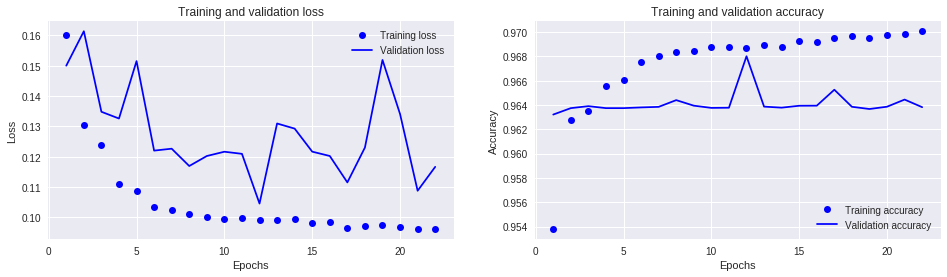

In [14]:
plot_history(history)

In [0]:
print(evaluate_on_test(model))

 9280/31915 [=======>......................] - ETA: 1:49